# Exercise 1 - Estimating simple relationships between stimulus & response
<hr style="height:2pt">

**VERY IMPORTANT** Before starting this tutorial, please go to "File -> Save As -> Save a Copy in Drive". This will save a local version that you can edit in your Google Drive. If you edit this version, **it will not save**. Alternatively, you can go to "Files -> Download -> Download .ipynb" and work on this locally in jupyter notebook.


In this problem set, you will investigate a very simple encoding model to understand the relationship between neural responses and the orientation of a presented drifting grating. 

In this problem set, you will learn to:
- Focus on Gaussian and Poisson likelihoods over scalar variables
- Use maximum likelihood estimation
- Investigate the impact of priors through comparing maximum a-posteriori estimates to maximum likelihood estimates
- Appreciate the value of regularization, and that priors provide such regularization
- Understand full posteriors and that those usually become ‘sharper’ with more data (i.e., reflect uncertainty)
- Perform frequentist model comparison through cross-validation
- Perform Bayesian model comparison through model evidence


Once you have completed the exercise, please describe the results of your exercise, and your interpretation of the results _(suggested length: 450-650 words)._ Use figures to help describe your results; please embed the figures in your text description. 

**Submit the write-up before noon on the day of the next session.**

Much of the crucial code is already implemented for you. Just follow the **TO-DO** signs to complete the problem set.


*Acknowledgements: This exercise was adapted by Ella Batty based on a previous version by Lucy Lai (graduate student in the Gershman Lab).*

For your convenience as you wrap up, all the to-dos are summarized here. Please note they make more sense in the context below though.


1. Derive the equation for the maximum likelihood estimator for $\lambda_j$. Include in write-up
2. Complete the functions `compute_gaussian_MLEs` and `compute_poisson_MLE`
3. Why is the Poisson likelihood higher than the Gaussian likelihood? In your write-up, please discuss your answer
4. Why are we not using an error function like mean squared error? In your write-up, please discuss your answer
5. Complete the function `compute_train_vs_test_likelihoods` below to compute train and test likelihoods for varying numbers of bins
6. Based on the two plots above, discuss the following questions in the write-up:
    - Can the training log likelihood ever decrease for increasing number of bins? Why or why not?
    - For neuron 3, what number of bins leads to the best model according to cross-validation? Describe how you determine this. Compare this to neuron 5
7. Complete the function `compute_poisson_MAP`, using equation 3
8. Discuss the following in your write-up
    - What do $\alpha$ and $\beta$ in the Gamma prior of the Poisson model seem to control? 
    - How does location and variance of prior affect the posterior?
    - How does the amount of data affect the interplay between likelihood, prior, and posterior?
    - The prior and posterior densities integrate to one (i.e., the areas under the curve sum to one). This does not seem to be the case for the likelihood when plotted over lambda. Why do you think this is the case?
9. In your write-up, discuss:
    - How does the effect of the prior vary with the variance of the prior?
    - What value of firing rate are the MAP estimates pulled towards (from the ML estimates)?
    - Does the prior exert more influence with more or less data? Why might that be?
10. In your write-up, discuss:
    - Why doesn't the MLE estimate change for different variances of the prior?
    - With all the training trials (32), does using the prior and MAP estimation always help over the MLE estimation? Does it sometimes help?
    - With less data (number of training trials), does the prior/MAP estimation help more or less? Why would this be the case?
    - Is there anything we could change to try and make this prior improve performance more? Why might this prior be especially unhelpful for neuron 5?
    - How do you think using a prior relates to regularization?
11. In your write-up, discuss:
    - Do model evidence and cross-validation always pick the same model as best?
    - Why might they pick different models if they do?
    - What assumptions, if any, does either approach make about the data?
    - How data-efficient is either approach?

In [19]:
from typing import Optional

import ipywidgets as widgets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.special
import seaborn as sns

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

## Section 1: Loading & visualizing data

We will use the dataset from http://bethgelab.org/datasets/v1gratings/, used in http://bethgelab.org/media/publications/EckerEtAl2010_all.pdf. 

The experimenters had macaque monkeys view drifting gratings of different orientations while performing extracellular recordings in primary visual cortex (V1). We have the recordings of 6 neurons responding to drifting gratings of 16 different orientations. We will used the total number of spikes during the presentation of each grating (so the summed spikes during the 500ms duration that the stimulus was on).

We load in the dataset in the cell below. If you are using Google Colab for this homework, it should download automatically. If you run into problems, try swapping out the id following `!gdown --id` in the first line below with `17YMYOhksunnXqjrQH2rWCKyXfsFnFj4P`. If you are using jupyter notebook locally, you need to download the data from https://drive.google.com/uc?id=1IRZWu7qJNH8Ddsg7dkDdACx_2NAKm1mi into the same folder and comment out the first line.

- `ori` is an array of shape (16,), containing the 16 orientations
- `spikes` is an array of shape (6, 16, 40), containing the summed spike counts for  6 neurons x 16 orientations x 40 trials per orientation

In [3]:
data = sio.loadmat("data/v1_data.mat")

ori = data["ori"].flatten()  # stimulus orientation
spikes = data["spk"]  # spike counts

n_neurons = 6  # number of neurons
n_ori = 16  # number of orientations
n_trials = 40  # number of trials per orientation
bin_width = 0.5  # time bin for spike counts (s)

In [4]:
data["spk"].shape

(6, 16, 40)

Execute the cell below to visualize the tuning curves of the 6 recorded neurons

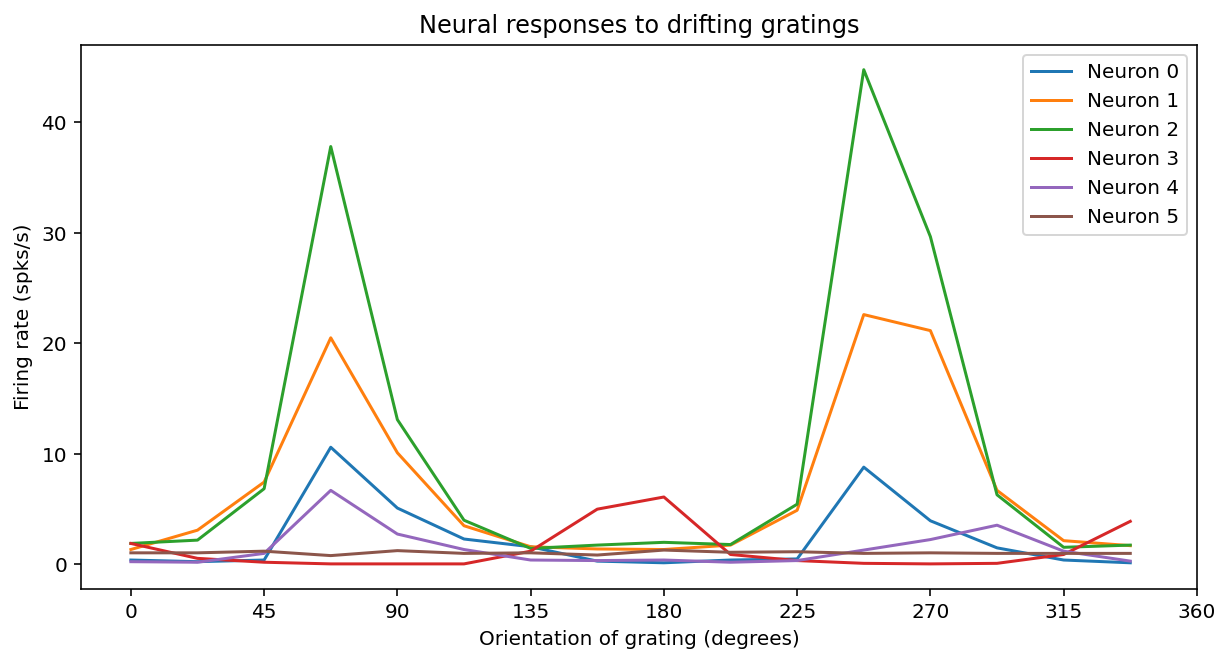

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Loop over neurons
for i in range(spikes.shape[0]):
    # Average spike counts over repetition and convert to firing rate.
    tuning_curve = np.mean(spikes[i], axis=1) / bin_width
    ax.plot(ori, tuning_curve, label=f"Neuron {i}")

ax.set(
    title="Neural responses to drifting gratings",
    xlabel="Orientation of grating (degrees)",
    ylabel="Firing rate (spks/s)",
    xticks=np.arange(0, 361, 45),
)
ax.legend();

## Section 2: Maximum Likelihood Estimation

In our data, we have a series of trials with a **presented stimulus $x$**(drifting grating described fully by its orientation) and an **associated neural response $y$** (the summed spike count). Our goal is to model the **conditional probability of the neural response given the stimulus and some model with parameters $\theta$: $p(y | x, \theta)$**. We will use a different parameter $\theta_j$ for each for each orientation $j$ to capture orientation-specific neural responses:

$$p(y_j | x_j, \theta_j)$$

We will be using two response models (i.e. probability distributions to capture neural responses). The first assumes that the summed spike count for each orientation is drawn from a *Gaussian distribution* with a different mean, $\mu_j$, and standard deviation, $\sigma_j$, for each orientation $j$.  The second assumes that the spike count for each orientation is drawn from a *Poisson distribution* with a different mean, $\lambda_j$, for each orientation. 

In this section, we will investigate how to estimate these parameters ($\mu_j$, $\sigma_j$, and $\lambda_j$) using maximum likelihood estimation. We will first go through the math of deriving equations for the maximum likelihood estimators in Section 2.1. Then, in Section 2.2, we will compute these estimates using code and our data. In the third section, we will compare the likelihood given these two models.

### Section 2.1: Deriving maximum likelihood estimators

Recall that to find the maximum likelihood estimate of a parameter $\theta$, we find the value of that parameter that maximizes the log likelihood:

\begin{align}
\hat{\theta}_{MLE} = \text{argmax$_{\theta}$ } \log p(y_{j, 1:N_j} | x_j, \theta)
\end{align}

Here we write $y_{j, 1:N_j}$ to include the data from all trials for this grating orientation, trial 1 through trial $N_j$. We can find the parameter that maximizes the log likelihood by taking the derivative of the log-likelihood with respect to that parameter, setting it equal to zero, and solving for the parameter.

#### Gaussian distribution

The Gaussian response model assumes that:

\begin{align}
p(y_{j, n} | x_j, \mu_j, \sigma_j) &= \mathcal{N}(y_{j, n} | \mu_j\Delta, \sigma_j^2\Delta) \\
&= \frac{1}{\sqrt{2\pi\sigma_j^2\Delta}}e^{-\frac{(y_{j,n} - \mu_j\Delta)^2}{2\sigma_j^2\Delta}},
\end{align}
where $y_{j, n}$ is the spike count for orientation $j$ and trial $n$, $\mu_j$ is the mean of the Gaussian distribution for orientation $j$, $\sigma_j$ is the standard deviation of the Gaussian distribution for orientation $j$, and $\Delta$ is the time bin width in seconds (`bin_width` in our code).

We assume the recorded responses to be independent and identically distributed (i.i.d.) across trials. This makes the likelihood for orientation $j$:
\begin{align}
p(y_{j, 1:N_j} | x_j, \mu_j,\sigma_j) &= \prod_{n=1}^{N_j}p(y_{j,n} |x_j, \mu_j, \sigma_j)\\
&= \prod_{n=1}^{N_j} \left( \frac{1}{\sqrt{2\pi\sigma_j^2\Delta}}e^{-\frac{(y_{j,n} - \mu_j\Delta)^2}{2\sigma_j^2\Delta}} \right)
\end{align}

We want to find the log-likelihood as it yields the same maximum likelihood parameter, but is easier to work with. The log-likelihood for the Gaussian response model is given by:

\begin{align}
logp(y_{j, 1:N_j}|x_j,\mu_j, \sigma_j) = -\frac{N_j}{2}log\sigma^2_j - \frac{1}{2\sigma_j^2\Delta}\sum_{n=1}^{N_j}(y_{j,n} - \mu_j\Delta)^2 + \text{const}
\end{align}

We now want to find the values of $\mu_j$ and $\sigma_j$ that maximize this expression. Note that the first term doen't depend on $\mu_j$ so we only focus on the second term to estimate $\mu_j$. This second term is proportional to negative mean squared error, a common error function! The $\mu_j$ that maximizes this second term is the same one that minimizes mean squared error.

Setting the derivative of the log-likelihood with respect to $\mu_j$ to zero and solving for $\mu_j$ reveals that its maximum likelihood estimate is independent of $\sigma_j^2$, and given by

\begin{align}
\hat{\mu}_{j,ML} = \frac{1}{N_j\Delta}\sum_{n=1}^{N_j}y_{j,n}\tag{1}
\end{align}

Applying the same procedure to find the maximum likelihood estimate of $\sigma_j^2$ yields 

\begin{align}
\hat{\sigma}_{j, MLE}^2 = \frac{1}{N_j\Delta}\sum_{n=1}^{N_j}(y_{j, n} - \hat{\mu}_{j,ML}\Delta)^2
\tag{2}
\end{align}

Note that this estimate is biased, as it doesn't contain Bessel's correction (i.e., a normalization by $(N_j - 1)^{-1}$ rather than $N_j^{-1}$).

#### Poisson distribution

The Poisson response model assumes that:

\begin{align}
p(y_{j, n} | x_j, \lambda_j) &= Poiss(y_{j, n} | \lambda_j\Delta) \\
&= \frac{(\lambda_j\Delta)^{y_{j,n}}}{y_{j, n}!}e^{-\lambda_j\Delta},
\end{align}
where $y_{j, n}$ is the spike count for orientation $j$ and trial $n$, $\lambda_j$ is the mean of the Poisson distribution for orientation $j$, and $\Delta$ is the time bin width in seconds (`bin_width` in our code).

We assume the recorded responses to be independent across trials. This makes the likelihood for orientation $j$ to be given by:
\begin{align}
p(y_{j, 1:N_j} | x_j, \lambda_j) &= \prod_{n=1}^{N_j}p(y_{j,n} |x_j,\lambda_j)\\
&= \prod_{n=1}^{N_j} \left( \frac{(\lambda_j\Delta)^{y_{j,n}}}{y_{j, n}!}e^{-\lambda_j\Delta} \right)
\end{align}

We want to find the log-likelihood as this is easier to work with:
\begin{align}
logp(y_{j, 1:N_j} | x_j, \lambda_j) &= \log \prod_{n=1}^{N_j}(\frac{(\lambda_j\Delta)^{y_{j,n}}}{y_{j, n}!}e^{-\lambda_j\Delta}) \\
&= \sum_{n=1}^{N_j}\log \left( \frac{(\lambda_j\Delta)^{y_{j,n}}}{y_{j, n}!}e^{-\lambda_j\Delta} \right)\\
&= \sum_{n=1}^{N_j}(y_{j,n}\log(\lambda_j\Delta) - \lambda_j\Delta - \log(y_{j,n}!))\\
&= \log(\lambda_j\Delta)\sum_{n=1}^{N_j}y_{j,n} - N_j\lambda_j\Delta - \sum_{n=1}^{N_j}\log(y_{j,n}!)
\end{align}

**TO-DO: Derive the equation for the maximum likelihood estimator for $\lambda_j$. Include in write-up** ✅

The strategy is the same as above for the Gaussian distribution, take the derivative of the log-likelihood w.r.t $\lambda_j$, set the result equal to 0, and solve for $\lambda_j$.

1. Derivative of the log-likelihood w.r.t to $\lambda_j$.

\begin{aligned}
\frac{d}{d \lambda_j} p(y_{j, 1:N_j} | x_j, \lambda_j) &= 
  \left( \frac{1}{\lambda_j \Delta} \Delta \right) \sum_{n=1}^{N_j} y_{j,n} - N_j \Delta - 0 \\
  &= \frac{1}{\lambda_j} \sum_{n=1}^{N_j} y_{j,n} - N_j \Delta
\end{aligned}

2. Set equal to zero and solve for $\lambda_j$.

\begin{aligned}
0 &= \frac{d}{d \lambda_j} p(y_{j, 1:N_j} | x_j, \lambda_j) \\
0 &= \frac{1}{\lambda_j} \sum_{n=1}^{N_j} y_{j,n} - N_j \Delta \\
\frac{1}{\lambda_j} \sum_{n=1}^{N_j} y_{j,n} &= N_j \Delta \\
\hat{\lambda}_j &= \frac{1}{N_j \Delta} \sum_{n=1}^{N_j} y_{j,n}
\end{aligned}

Therefore, the MLE for $\lambda_j$ is just the mean of the summed spike counts for orientation $j$.

### Section 2.2: Finding MLEs using data

Now that you have equations for the maximum likelihood estimates of the Gaussian and Poisson from Section 2.1, let's implement them in code to actually estimate these parameters for the first neuron using our data. 

We will then plot $\mu_j$ and $\lambda_j$ over orientation - these are the mean of the Gaussian and Poisson distributions respectively, so we can compare to the actual spike count, where the  blue line shows the mean spike count over trials and the shaded region shows the standard deviation.

In [6]:
def visualize_fits(
    spikes_train: Optional[np.ndarray],
    i_neuron: int,
    spikes_test: Optional[np.ndarray] = None,
    fit1: Optional[np.ndarray] = None,
    label1: Optional[str] = None,
    fit2: Optional[np.ndarray] = None,
    label2: Optional[str] = None,
    ax: Optional[plt.Axes] = None,
) -> None:
    """Visualize fits of encoding models to neural data

    Args:
        spikes_train (ndarray): n_neurons x n_oris x n_trials array of training data spike counts
        i_neuron (scalar): which neuron to visualize
        spikes_test (ndarray): n_neurons x n_oris x n_trials array of testing data spike counts
        fit1 (ndarray): n_oris shape array containing the fits for the first encoding model
        label1 (str): legend label for fit1
        fit2 (ndarray): n_oris shape array containing the fits for the second encoding model (optional)
        label2 (str): legend label for fit2 (optional)
        ax: matplotlib axis object (optional)

    Returns:
        Nothing, just makes a plot
    """

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # Raw train data
    if spikes_train is not None:
        means = np.mean(spikes_train[i_neuron] / bin_width, axis=1)
        sds = np.std(spikes_train[i_neuron] / bin_width, axis=1)
        ax.plot(ori, means, "-o", color="tab:blue", label="Raw train data")
        ax.fill_between(ori, means - sds, means + sds, color="tab:blue", alpha=0.2)

    # Raw test data
    if spikes_test is not None:
        means = np.mean(spikes_test[i_neuron] / bin_width, axis=1)
        sds = np.std(spikes_test[i_neuron] / bin_width, axis=1)
        ax.plot(ori, means, "-o", color="tab:orange", label="Raw test data")
        ax.fill_between(ori, means - sds, means + sds, color="tab:orange", alpha=0.2)

    if fit1 is not None:
        ax.plot(ori, fit1, "-o", color="tab:green", alpha=0.8, label=label1)

    if fit2 is not None:
        ax.plot(ori, fit2, "-o", color="tab:red", alpha=0.8, label=label2)

    ax.set(
        xlabel="Orientation (degrees)",
        ylabel="Firing rate (spks/s)",
        xticks=np.arange(0, 361, 45),
    )

    ax.legend()

#### Gaussian Distribution

**TO-DO: Complete the functions `compute_gaussian_MLEs` and `compute_poisson_MLE`** ✅

In [7]:
spikes.shape

(6, 16, 40)

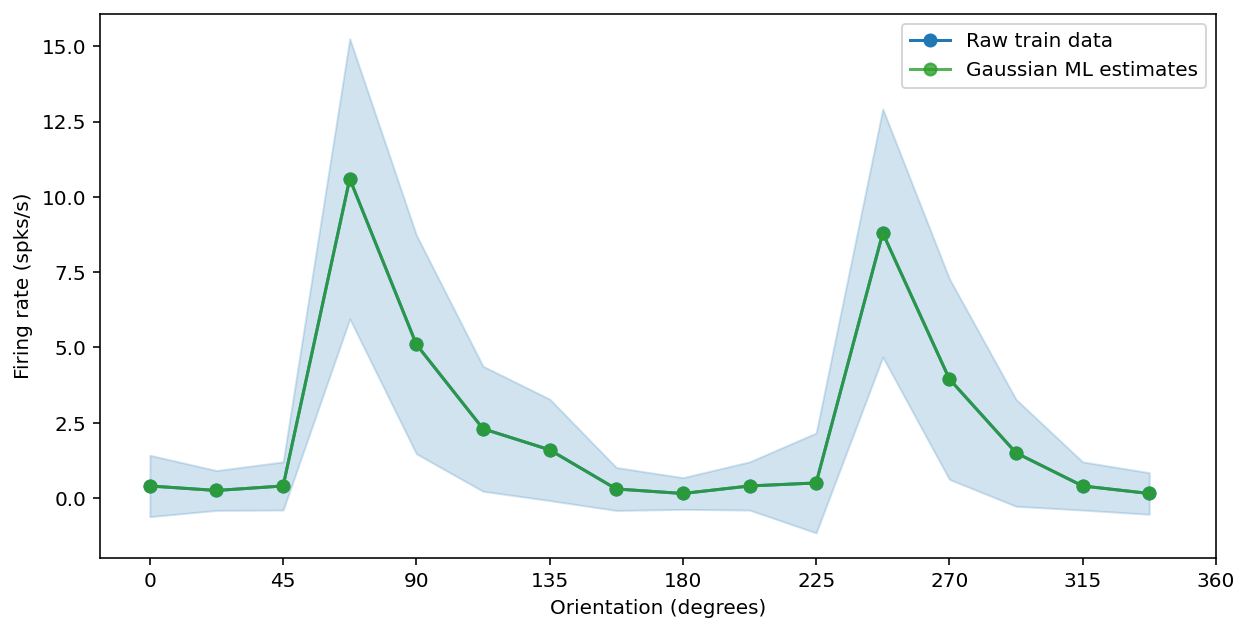

In [8]:
def compute_gaussian_MLEs(
    spikes: np.ndarray, i_neuron: int
) -> tuple[np.ndarray, np.ndarray]:
    """Compute MLE estimates of mu and sigma for Gaussian model

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        i_neuron (scalar): which neuron to estimate parameters for

    Returns:
        (ndarray, ndarray): (n_oris, ) array of maximum likelihood estimates for mu for each orientation,
                            (n_oris, ) array of maximum likelihood estimates for sigma for each orientation

    """

    n_trials = spikes.shape[2]

    # Set up array for storing maximum likelihood estimators
    gaussian_mu_ML = np.zeros(n_ori)
    gaussian_sigma_ML = np.zeros(n_ori)

    Z = 1 / (n_trials * bin_width)

    # Loop over orientation
    for j in range(0, n_ori):

        # TO DO: compute mu MLE (eq. 1)
        gaussian_mu_ML[j] = Z * spikes[i_neuron, j, :].sum()

        # TO DO: compute sigma MLE (eq. 2)
        _sum = np.sum((spikes[i_neuron, j, :] - gaussian_mu_ML[j] * bin_width) ** 2)
        gaussian_sigma_ML[j] = Z * _sum

    return gaussian_mu_ML, gaussian_sigma_ML


i_neuron = 0
gaussian_mu_ML, gaussian_sigma_ML = compute_gaussian_MLEs(spikes, i_neuron)

# Visualize estimates on top of real data
visualize_fits(spikes, i_neuron, fit1=gaussian_mu_ML, label1="Gaussian ML estimates")

#### Poisson distribution

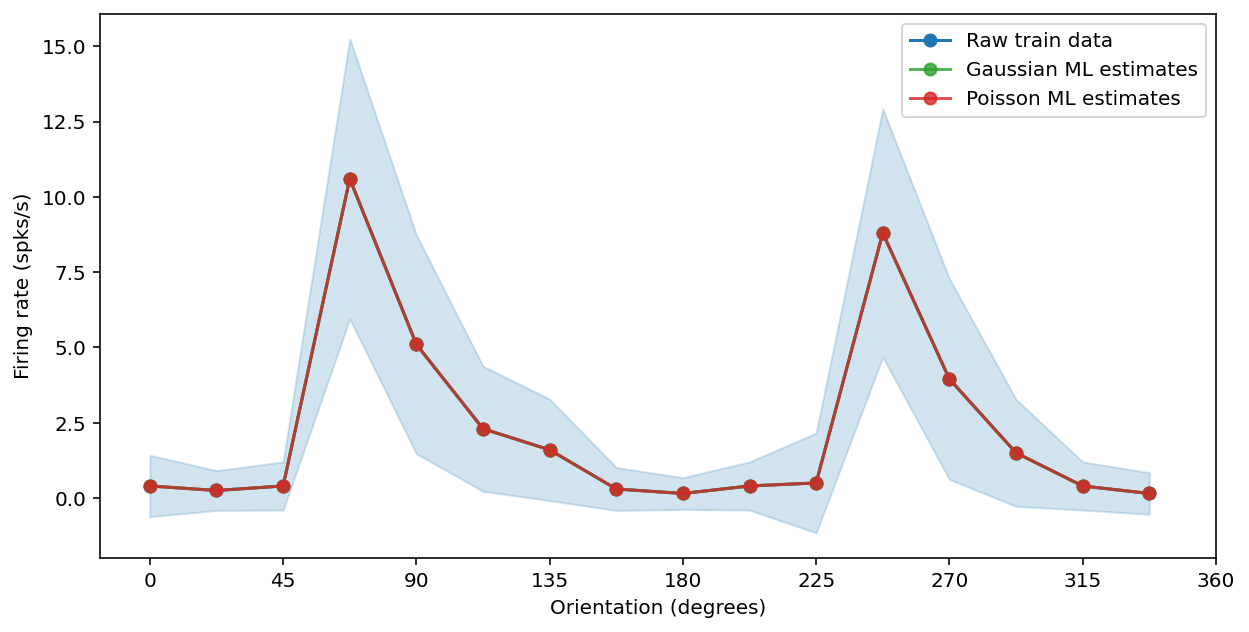

In [9]:
def compute_poisson_MLE(spikes: np.ndarray, i_neuron: int) -> np.ndarray:
    """Compute MLE estimate of lambda for Poisson model

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        i_neuron (scalar): which neuron to estimate parameters for

    Returns:
        ndarray: (n_oris, ) array of maximum likelihood estimates for lambda for each orientation

    """

    n_trials = spikes.shape[2]

    # Set up array for storing maximum likelihood estimators
    poisson_lambda_ML = np.zeros(n_ori)

    Z = 1 / (n_trials * bin_width)

    # Loop over orientation
    for j in range(0, n_ori):

        # TO-DO: compute lambda
        poisson_lambda_ML[j] = Z * spikes[i_neuron, j, :].sum()

    return poisson_lambda_ML


i_neuron = 0
poisson_lambda_ML = compute_poisson_MLE(spikes, i_neuron)


# Visualize estimates on top of real data
visualize_fits(
    spikes,
    i_neuron,
    fit1=gaussian_mu_ML,
    label1="Gaussian ML estimates",
    fit2=poisson_lambda_ML,
    label2="Poisson ML estimates",
)

### Section 2.3: Computing & comparing likelihoods

In the cell below, we compute the Poisson and Gaussian likelihoods given the maximum likelihood estimates you computed above. I divide by the number of trials (so computing the average log-likelihood over trials) so we can compare likelihoods for different numbers of trials more easily.

**TO-DO: Why is the Poisson likelihood higher than the Gaussian likelihood? In your write-up, please discuss your answer** (Hint: Think about what type of random variables both distributions are defined for.) ✅

Realizations from the Gaussian distribution can be any real number whereas those from a Poisson distribution are restricted to non-negatives. The difference due to these properties of the distributions manifests as the distributions localize near 0 because the likelihood under the Poisson distribution will be restricted by the lower bound whereas the Gaussian distribution is not.
In this case, the Poisson perhaps provides a more natural description of the distribution of spike counts because they are non-negative integer values and the underlying explanatory parameter can be thought of as a rate, a common descriptor for the Poisson parameter $\lambda$.

In [10]:
def compute_Gaussian_log_likelihood(
    spikes: np.ndarray,
    i_neuron: int,
    gaussian_mu: np.ndarray,
    gaussian_sigma: np.ndarray,
    bin_width: float,
) -> float:
    """Compute Gaussian log likelihood given data and Gaussian parameters

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        i_neuron (scalar): which neuron to estimate parameters for
        gaussian_mu (ndarray): array of shape (n_oris,) containing estimate for
                               Gaussian mean (mu) for each orientation
        gaussian_sigma (ndarray): array of shape (n_oris,) containing estimate for
                               Gaussian standard deviation (sigma) for each orientation
        bin_width (float): bin length in seconds


    Returns:
        float: Gaussian log-likelihood across orientations

    """

    # Initialize array to save log likelihood per orientation
    ori_log_likelihoods = np.zeros((n_ori,))

    # Loop over orientations
    for i_ori in range(n_ori):

        # Compute log likelihood for this orientation
        ori_log_likelihoods[i_ori] = np.mean(
            -0.5 * np.log(2 * np.pi * gaussian_sigma[i_ori] ** 2 * bin_width)
            - (spikes[i_neuron, i_ori] - gaussian_mu[i_ori] * bin_width) ** 2
            / (2 * gaussian_sigma[i_ori] ** 2 * bin_width)
        )

    return np.mean(ori_log_likelihoods)


i_neuron = 0
gaussian_mu_ML, gaussian_sigma_ML = compute_gaussian_MLEs(spikes, i_neuron)
Gaussian_log_likelihood = compute_Gaussian_log_likelihood(
    spikes, i_neuron, gaussian_mu_ML, gaussian_sigma_ML, bin_width
)

print(f"The Gaussian log likelihood equals {Gaussian_log_likelihood:.2f}")
print(f"The Gaussian likelihood equals {np.exp(Gaussian_log_likelihood):.2f}")

The Gaussian log likelihood equals -1.62
The Gaussian likelihood equals 0.20


In [11]:
def compute_Poisson_log_likelihood(
    spikes, i_neuron, poisson_lambda, bin_width, n_ori=16
):
    """Compute Poisson log likelihood given data and Poisson parameters

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        i_neuron (scalar): which neuron to estimate parameters for
        poisson_lambda (ndarray): array of shape (n_oris,) containing estimate for
                               Poisson mean (lambda) for each orientation
        bin_width (float): bin length in seconds


    Returns:
        float: Poisson log-likelihood across orientations

    """

    # Get number of trials
    n_trials = spikes.shape[2]

    # Initialize array to save log likelihood per orientation
    ori_log_likelihoods = np.zeros((n_ori,))

    # Loop over orientations
    for i_ori in range(n_ori):

        # Compute log likelihood for this orientation
        ori_log_likelihoods[i_ori] = (
            np.log(poisson_lambda[i_ori] * bin_width + 1e-6)
            * np.sum(spikes[i_neuron, i_ori])
            - n_trials * poisson_lambda[i_ori] * bin_width
            - np.sum(scipy.special.gammaln(spikes[i_neuron, i_ori] + 1))
        )

    return np.mean(ori_log_likelihoods) / n_trials


i_neuron = 0
poisson_lambda_ML = compute_poisson_MLE(spikes, i_neuron)
poisson_log_likelihood = compute_Poisson_log_likelihood(
    spikes, i_neuron, poisson_lambda_ML, bin_width
)

print(f"The Poisson log likelihood equals {poisson_log_likelihood:.2f}")
print(f"The Poisson likelihood equals {np.exp(poisson_log_likelihood):.2f}")

The Poisson log likelihood equals -1.00
The Poisson likelihood equals 0.37


## Section 3: Frequentist model comparison: cross-validation

Let's stick to our Poisson model and dive deeper. So far, we've learned how to estimate the best $\lambda_j$ for each orientation $j$. What if it would be better to learn the same $\lambda$ for pairs of consecutive orientations? For example, we could assume the neuron has the same response to 0 degree gratings and 22.5 degree gratings.

Alternatively, we could learn the same $\lambda$ for every grouping of four orientations, or eight, or so on. This could perform better as we'd have more data for each parameter we're estimating (as we're combining data from 2, 4, or more orientations).

Let's try it out! We can control the number of bins we use for the orientation data. So far, we've used 16 bins. We could use 8 bins to group pairs of orientations, 4 bins to group every four orientations, and so on.

So how can we ultimately determine which model (i.e. which number of bins) is best? We can split our data into train and test data and evaluate the performance of each model on the test data - this is cross-validation! In order to evaluate the performance of each model, we need a metric of model performance that we can compute. We will use the Poisson likelihood.

**TO-DO: Why are we not using an error function like mean squared error? In your write-up, please discuss your answer.** ✅

We do not use an error function like the mean squared error because that would penalize over-estimates and under-estimates of the same magnitude equally, but our likelihood function, the Poisson distribution, is not symmetrical.
Therefore, the using the log-likelihood is preferable in this situation, because it naturally accounts for the asymmetry of the distribution.

Below, we have helper functions to split the data into train and test sets (`split_train_test`) and to fit our model with different number of bins (`varying_bins_MLE`).

**TO-DO: Complete the function `compute_train_vs_test_likelihoods` below to compute train and test likelihoods for varying numbers of bins.** (Hint: you should be able to reuse a function we've already seen.) ✅

In [12]:
# @markdown Execute to enable helper functions `split_train_test` and `varying_bins_MLE`
def split_train_test(spikes, n_trials=n_trials, train_split=0.8, seed=123):
    """Split data into train and test segments

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        n_trials (scalar): number of total trials
        train_split (scalar): proportion of data assigned to train split
        seed (scalar): random seed so you can get the same split back reproducibly


    Returns:
        ndarray, ndarray: training data in array of shape n_neurons x n_oris, x n train trials,
                          testing data in array of shape n_neurons x n_oris, x n test trials,

    """

    # Set random seed
    np.random.seed(seed)

    # Compute numbers of train and test trials
    n_train = int(np.floor(train_split * n_trials))
    n_test = n_trials - n_train

    # Define trials as train or test
    train_inds = np.random.choice(np.arange(n_trials), size=(n_train))
    test_inds = np.setdiff1d(np.arange(n_trials), train_inds)

    # Extract train and test subsets
    spikes_train = spikes[:, :, train_inds]
    spikes_test = spikes[:, :, test_inds]

    return spikes_train, spikes_test


def varying_bins_MLE(spikes, i_neuron, n_bins):
    """Compute Poisson lambda ML estimates given number of orientation bins

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        i_neuron (scalar): which neuron to estimate parameters for
        n_bins (scalar): number of orientation bins

    Returns:
        ndarray: (n_oris, ) array of maximum likelihood estimates for lambda for each orientation

    """

    # Set up array where each row is a bin and entries
    # define orientations within that bin
    oris = np.arange(n_ori).reshape((n_bins, -1))

    n_oris_per_bin = oris.shape[1]
    n_train_trials = spikes[i_neuron].shape[1]

    # Set up array for storing maximum likelihood estimators
    poisson_lambda_ML = np.zeros(n_ori)

    # Loop over bins
    for i_ori in range(0, n_ori):

        # Get which orientation bin this orientation belongs to
        which_bin = np.where(oris == i_ori)[0][0]

        # Compute estimate
        poisson_lambda_ML[i_ori] = (
            1 / (n_train_trials * n_oris_per_bin * bin_width)
        ) * np.sum(spikes[i_neuron, oris[which_bin], :])

    return poisson_lambda_ML

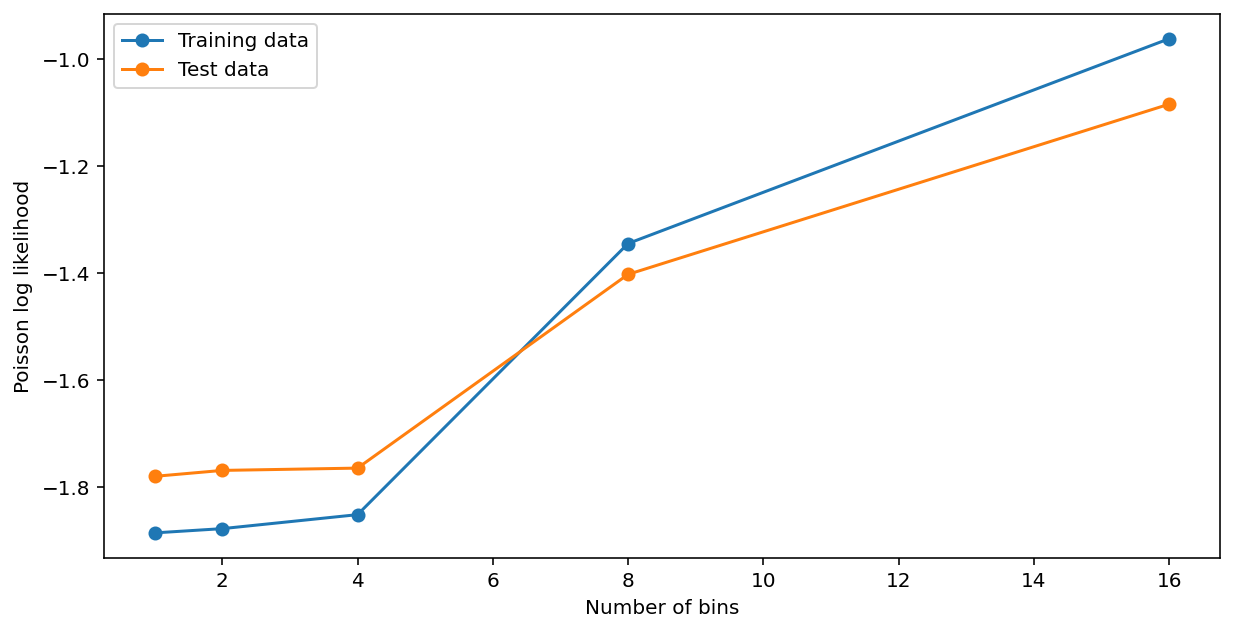

In [13]:
def compute_train_vs_test_likelihoods(
    spikes: np.ndarray, i_neuron: int, n_bins_options: np.ndarray, bin_width: float
) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Compute Poisson log likelihood for train and test data for different orientation binning options

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        i_neuron (scalar): which neuron to estimate parameters for
        n_bins_options (ndarray): array containing different number of orientation bins to
                  fit and evaluate models for
        bin_width (float): bin length in seconds


    Returns:
        ndarray, ndarray: train log likelihoods for the different bin options,
                          test log likelihoods for the different bin options,

    """

    # Divide spikes into train and test
    spikes_train, spikes_test = split_train_test(spikes)

    # Set up error arrays
    train_log_likelihood = np.zeros((len(n_bins_options)))
    test_log_likelihood = np.zeros((len(n_bins_options)))

    # Loop over number of bins
    for i, n_bins in enumerate(n_bins_options):

        # Fit model
        poisson_lambda_ML = varying_bins_MLE(spikes_train, i_neuron, n_bins)

        # Compute training error
        train_log_likelihood[i] = compute_Poisson_log_likelihood(
            spikes_train, i_neuron, poisson_lambda_ML, bin_width
        )

        # Compute test error
        test_log_likelihood[i] = compute_Poisson_log_likelihood(
            spikes_test, i_neuron, poisson_lambda_ML, bin_width
        )

    return train_log_likelihood, test_log_likelihood, spikes_train, spikes_test


i_neuron = 0
n_bins_options = np.array([1, 2, 4, 8, 16])
train_log_likelihood, test_log_likelihood, _, _ = compute_train_vs_test_likelihoods(
    spikes, i_neuron, n_bins_options, bin_width
)

# Visualize error
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(n_bins_options, train_log_likelihood, "-o", label="Training data")
ax.plot(n_bins_options, test_log_likelihood, "-o", label="Test data")
ax.legend()
ax.set(xlabel="Number of bins", ylabel="Poisson log likelihood");

See the demo below to visualize the prior plot for different neurons and the model fits for different neurons and varying numbers of bins. 

In [14]:
@widgets.interact(
    i_neuron=widgets.SelectionSlider(
        options=[0, 1, 2, 3, 4, 5], description="i_neuron"
    ),
    n_bins=widgets.SelectionSlider(options=[1, 2, 4, 8, 16], description="n_bins"),
)
def plot_estimates(i_neuron, n_bins):

    n_bins_options = np.array([1, 2, 4, 8, 16])
    (
        train_log_likelihood,
        test_log_likelihood,
        spikes_train,
        spikes_test,
    ) = compute_train_vs_test_likelihoods(spikes, i_neuron, n_bins_options, bin_width)

    # Visualize error
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    axes[0].plot(n_bins_options, train_log_likelihood, "-o", label="Training data")
    axes[0].plot(n_bins_options, test_log_likelihood, "-o", label="Test data")
    axes[0].legend()
    axes[0].set(
        xticks=n_bins_options, xlabel="Number of bins", ylabel="Poisson log likelihood"
    )

    poisson_lambda_ML = varying_bins_MLE(spikes_train, i_neuron, n_bins)
    visualize_fits(
        spikes_train,
        i_neuron,
        spikes_test=spikes_test,
        fit1=poisson_lambda_ML,
        label1="Poisson ML estimates",
        ax=axes[1],
    )

interactive(children=(SelectionSlider(description='i_neuron', options=(0, 1, 2, 3, 4, 5), value=0), SelectionS…

**TO-DO: Based on the two plots above, discuss the following questions in the write-up:** ✅
- Can the training log likelihood ever decrease for increasing number of bins? Why or why not?
- For neuron 3, what number of bins leads to the best model according to cross-validation? Describe how you determine this. Compare this to neuron 5

Assuming that bins are combined/split per the strategy above, the training log-likelihood cannot decrease by increasing the number of bins because we are calculating the maximum likelihood estimate for $\lambda$ and the variance within each sub-bin can only decrease when one bin is split. As the number of bins increases, the MLE covers fewer observations and can become more precise for that subset of data.

For neuron 3, the best model used 16 bins. The log-likelihood was the highest for both the training and test data with 16 bins. There is a larger jump in the training log-likelihood and the testing from 8 to 6 bins, so with a full implementation of CV, it would be possible that 8 bins would be superior and 16 is over-fitting.

For neuron 5, the optimal number of bins was 1 because the testing log-likelihood only decreased for increasing number of bins indicating over-fitting.

In [23]:
for neuron in [3, 5]:
    train_log_likelihood, test_log_likelihood, _, _ = compute_train_vs_test_likelihoods(
        spikes, neuron, n_bins_options, bin_width
    )
    print(f"neuron: {neuron}")
    _df = pd.DataFrame(
        {
            "num. bins": n_bins_options,
            "train log-lik": train_log_likelihood,
            "test log-lik": test_log_likelihood,
        }
    )
    print(_df)

neuron: 3
   num. bins  train log-lik  test log-lik
0          1      -1.309024     -1.317052
1          2      -1.304940     -1.302146
2          4      -1.273722     -1.266321
3          8      -0.925337     -0.911187
4         16      -0.771082     -0.879056
neuron: 5
   num. bins  train log-lik  test log-lik
0          1      -0.930027     -0.844664
1          2      -0.929632     -0.845625
2          4      -0.928566     -0.847018
3          8      -0.917195     -0.857786
4         16      -0.913754     -0.863965


## Section 4: Maximum a-posteriori estimation

### Section 4.1: Deriving maximum a-posteriori estimate

Now, let's introduce a prior on the spiking responses to different orientations of gratings. This means that we will introduce prior knowledge about what the spiking responses are likely to be.

Remember that we find the 
maximum-a-posteriori estimate for $\theta$ by maximizing the log of the posterior probability of the parameter $\theta$ given the neural responses $y_{j, 1:N_j}$ and stimuli $x_j$: $p( \theta | y_{j, 1:N_j}, x_j)$. The log of the posterior probablity is equal to the log likelihood plus the log prior:

\begin{align}
\hat{\theta}_{MAP} &= \text{argmax$_{\theta}$  } \log p( \theta | y_{j, 1:N_j}, x_j) \\
&= \text{argmax$_{\theta}$  } [\log p( y_{j, 1:N_j} | x_j,  \theta) + \log p(\theta)] 
\end{align}

To keep the math tractable, we will use the conjugate prior for the Poisson likelihood, which is the Gamma distribution:

\begin{align}
p(\lambda_j) = Gam(\lambda_j | \alpha_j, \beta_j) = \frac{\beta_j^{\alpha_j}}{\Gamma(\alpha_j)}\lambda_j^{\alpha_j - 1}e^{-\beta_j\lambda_j}
\end{align}
with shape $\alpha_j > 0$ and rate $\beta_j > 0$. This prior results in the log-posterior:

\begin{align}
\log p(\lambda_j | y_{j, 1:N_j}, x_j) = -(\beta_j + N_j\Delta)\lambda_j + (\log\lambda_j) \left(\alpha_j - 1 + \sum_{n=1}^{N_j}y_{j, n}\right) + \text{const...}
\end{align}

Taking its derivative with respect to $\lambda_j$ and setting it to zero results in the MAP estimate:

\begin{align}
\lambda_{j, MAP} &= \frac{\alpha_j - 1 + \sum_{n=1}^{N_j}y_{j,n}}{\beta_j + N_j\Delta} \tag{3}\\
&= \frac{\beta_j}{\beta_j + N_j\Delta}\frac{\alpha_j - 1}{\beta_j} + \frac{N_j\Delta}{\beta_j + N_j\Delta}\hat{\lambda}_{j, ML}
\end{align}

The second expression shows that the MAP estimate for $\lambda_j$ is a weighted combination of the prior mode, $(\alpha_j - 1)/\beta_j$, and the maximum-likelihood estimate $\hat{\lambda}_{j, ML}$. It furthermore illustrates that $\beta_j$ controls the strength of the prior in terms of numbers of trials.

As we have used conjugate priors, the posteriors will have the same distributional form as the priors. This allows us to directly read out the posterior parameters from the above log-posterior.  The posterior $\lambda_j$ will be Gamma distribution, and is, by the above log-posterior, given by

\begin{align}
p(\lambda_j | y_{j, 1:N_j}) = Gam\left(\lambda_j | \alpha_j + \sum_{n=1}^{N_j}y_{j, n}, \beta_j + N_j\Delta\right)
\end{align}

Note that the mode of this posterior corresponds to $\hat{\lambda}_{j, MAP}$, as required.

We will assume we have the same prior on every orientation bin, so we can drop the subscript j for $\alpha$ and $\beta$. We'll also go back to using 16 bins for the 16 orientations.


### Section 4.2: Computing maximum a-posteriori estimate

Let's compute the maximum a posterior estimates for all orientations. 

**TO-DO: Complete the function `compute_poisson_MAP`, using equation 3**


In [ ]:
def compute_poisson_MAP(spikes, i_neuron, alpha, beta):
    """Compute MAP estimate of lambda for Poisson model

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        i_neuron (scalar): which neuron to estimate parameters for
        alpha (scalar): parameter of Gamma prior
        beta (scalar): parameter of Gamma prior

    Returns:
        ndarray: (n_oris, ) array of maximum likelihood estimates for lambda for each orientation

    """

    n_trials = spikes.shape[2]

    # Set up array for storing estimators
    poisson_lambda_MAP = np.zeros(n_ori)

    # Loop over orientation
    for i_ori in range(0, n_ori):

        # TO-DO: compute lambda
        poisson_lambda_MAP[i_ori] = ...

    return poisson_lambda_MAP


i_neuron = 0

# Compute MLE
poisson_lambda_MLE = compute_poisson_MLE(spikes, i_neuron=0)

# Compute MAP
poisson_lambda_MAP = compute_poisson_MAP(spikes, i_neuron=0, alpha=10, beta=10)

# Visualize
visualize_fits(
    spikes,
    i_neuron,
    fit1=poisson_lambda_MLE,
    label1="Poisson ML estimates",
    fit2=poisson_lambda_MAP,
    label2="Poisson MAP estimates",
)

### Section 4.3: Examining effect of prior

Play with the demo below to see the prior impact on the posterior for the grating with orientation of 67.5. You can also change the amount of data (number of training trials) used to compute the likelihood and fit the MLE. The MLE is indicated by the dashed blue line and the MAP is indicated by the dashed red line.

**TO-DO: Discuss the following in your write-up**
- What do $\alpha$ and $\beta$ in the Gamma prior of the Poisson model seem to control? 
- How does location and variance of prior affect the posterior?
- How does the amount of data affect the interplay between likelihood, prior, and posterior?
- The prior and posterior densities integrate to one (i.e., the areas under the curve sum to one). This does not seem to be the case for the likelihood when plotted over lambda. Why do you think this is the case?

In [ ]:
# @markdown Execute this cell to enable the widget


@widgets.interact(
    alpha=widgets.FloatSlider(value=10, min=0, max=100, step=1),
    beta=widgets.FloatSlider(value=10, min=1, max=100, step=1),
    n_train_trials=widgets.IntSlider(value=40, min=1, max=40, step=1),
    continuous_update=False,
)
def plot_prior_effects(alpha, beta, n_train_trials):

    i_ori = 3

    lambda_vec = np.arange(0.1, 20, 0.1)

    prior = np.exp(
        alpha * np.log(beta)
        + (alpha - 1) * np.log(lambda_vec)
        - beta * lambda_vec
        - scipy.special.gammaln(alpha)
    )

    likelihood = np.exp(
        np.sum(
            spikes[i_neuron, i_ori, :n_train_trials][:, None]
            * np.log(lambda_vec[None, :] * bin_width)
            - np.log(
                scipy.special.factorial(
                    spikes[i_neuron, i_ori, :n_train_trials][:, None]
                )
            )
            - lambda_vec[None, :] * bin_width,
            axis=0,
        )
    )

    alpha_posterior = alpha + np.sum(spikes[i_neuron, i_ori, :n_train_trials])
    beta_posterior = beta + n_trials * bin_width
    posterior = np.exp(
        alpha_posterior * np.log(beta_posterior)
        + (alpha_posterior - 1) * np.log(lambda_vec)
        - beta_posterior * lambda_vec
        - scipy.special.gammaln(alpha_posterior)
    )

    fig, axes = plt.subplots(3, 1, figsize=(7, 7), sharex=True)

    axes[0].plot(lambda_vec, prior, "-r", label="prior")
    axes[0].set(title="Prior")

    axes[1].plot(lambda_vec, likelihood, "-b", label="likelihood")
    MLE = lambda_vec[np.argmax(likelihood)]
    axes[1].plot([MLE, MLE], axes[1].get_ylim(), "--b")
    axes[1].set(title="Likelihood")

    axes[2].plot(lambda_vec, posterior, "-", color="purple", label="posterior")

    MAP = lambda_vec[np.argmax(posterior)]
    axes[2].plot([MAP, MAP], axes[2].get_ylim(), "--", color="purple")
    axes[2].set(title="Posterior")

    axes[2].set(xlabel=r"$\lambda$ for orientation 67.5")

    plt.tight_layout()

Let's look at how the estimates for all orientations change with different priors. In the demo below, you can change the variance of the prior. The variance of a gamma distrbution equals $\alpha/\beta^2$. To make this more simple, we have prespecified that the mode of the prior on $\lambda$ equals 4 as that is very close to the mean of the data (`spikes.mean() / bin_width`). So, our prior knowledge is that the spikes per second tends to be around 4. You can also change the number of trials (amount of data) used to compute the MLE.

**TO-DO: In your write-up, discuss:**
- How does the effect of the prior vary with the variance of the prior?
- What value of firing rate are the MAP estimates pulled towards (from the ML estimates)?
- Does the prior exert more influence with more or less data? Why might that be?


In [ ]:
# @markdown Execute to enable demo
style = {"description_width": "initial"}


@widgets.interact(
    prior_variance=widgets.FloatSlider(
        value=1, min=0.001, max=10, step=0.1, style=style
    ),
    n_train_trials=widgets.IntSlider(value=40, min=1, max=40, step=1),
    continuous_update=False,
)
def plot_prior_effects(prior_variance, n_train_trials):
    prior_mode = 4
    lambda_vec = np.arange(0.1, 20, 0.1)

    beta = (prior_mode + np.sqrt(prior_mode ** 2 - 4 * prior_variance * -1)) / (
        2 * prior_variance
    )
    alpha = prior_mode * beta + 1

    # Compute full prior distribution
    prior = np.exp(
        alpha * np.log(beta)
        + (alpha - 1) * np.log(lambda_vec)
        - beta * lambda_vec
        - scipy.special.gammaln(alpha)
    )

    # Compute MLE
    poisson_lambda_MLE = compute_poisson_MLE(spikes[:, :, :n_train_trials], i_neuron=0)

    # Compute MAP
    poisson_lambda_MAP = compute_poisson_MAP(
        spikes[:, :, :n_train_trials], i_neuron=0, alpha=alpha, beta=beta
    )

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(lambda_vec, prior, "-r", label="prior")
    axes[0].set(title="Prior", xlabel=r"$\lambda_j$", ylabel="Prior probability")

    # Visualize
    visualize_fits(
        spikes[:, :, :n_train_trials],
        i_neuron,
        fit1=poisson_lambda_MLE,
        label1="Poisson ML estimates",
        fit2=poisson_lambda_MAP,
        label2="Poisson MAP estimates",
        ax=axes[1],
    )

### Section 4.4: Comparing different priors

We now are fitting different models with different priors. We can compare these models using cross-validation, just as we compared different models in Section 3. The only difference is that, previously, different models had different numbers of bins for the orientations, whereas here it's different priors.

Let's first compute for a grid of possible $\alpha$ and $\beta$ values.

In [ ]:
# @markdown Execute to compute test log likelihood for various alpha and beta values
# Specify neuron
i_neuron = 0

# Divide spikes into train and test
spikes_train, spikes_test = split_train_test(spikes)

# Outline alpha/beta options
alpha_options = np.arange(0, 20, 1)
beta_options = np.arange(1, 20, 1)

# Initialize log likelihood arrays
train_log_likelihood = np.zeros((len(alpha_options), len(beta_options)))
test_log_likelihood = np.zeros((len(alpha_options), len(beta_options)))

# Loop over alpha
for i_alpha, alpha in enumerate(alpha_options):

    # Loop over beta
    for i_beta, beta in enumerate(beta_options):

        # Compute MAP
        poisson_lambda_MAP = compute_poisson_MAP(spikes_train, i_neuron, alpha, beta)

        # Compute train log likelihood
        train_log_likelihood[i_alpha, i_beta] = compute_Poisson_log_likelihood(
            spikes_train, i_neuron, poisson_lambda_MAP, bin_width
        )

        # Compute test log likelihood
        test_log_likelihood[i_alpha, i_beta] = compute_Poisson_log_likelihood(
            spikes_test, i_neuron, poisson_lambda_MAP, bin_width
        )


# Visualize
fig, ax = plt.subplots(
    1,
    1,
)
im = ax.imshow(test_log_likelihood, origin="lower")
ax.set(title="Test Log Likelihood", xlabel="beta", ylabel="alpha")
fig.colorbar(im);

Instead of parameterizing by $\alpha$ and $\beta$, let's simplify by looking at performance while varying variance the prior, assuming a mode of 4 (close to the mean of the data). The green horizontal line shows the test error from the MLE estimate.

In [ ]:
# Specify neuron
i_neuron = 0

# Divide spikes into train and test
spikes_train, spikes_test = split_train_test(spikes)

# Compute MLE and corresponding log likelihoods
poisson_lambda_ML = compute_poisson_MLE(spikes_train, i_neuron)
poisson_train_log_likelihood = compute_Poisson_log_likelihood(
    spikes_train, i_neuron, poisson_lambda_ML, bin_width
)
poisson_test_log_likelihood = compute_Poisson_log_likelihood(
    spikes_test, i_neuron, poisson_lambda_ML, bin_width
)

# Outline prior options
variance_options = np.arange(0.1, 5, 0.1)
prior_mode = 4

# Initialize log likelihood arrays
train_log_likelihood = np.zeros((len(variance_options),))
test_log_likelihood = np.zeros((len(variance_options),))

# Loop over variances
for i_variance, prior_variance in enumerate(variance_options):

    # Convert mode and variance to alpha/beta
    beta = (prior_mode + np.sqrt(prior_mode ** 2 - 4 * prior_variance * -1)) / (
        2 * prior_variance
    )
    alpha = prior_mode * beta + 1

    # Compute MAP
    poisson_lambda_MAP = compute_poisson_MAP(spikes_train, i_neuron, alpha, beta)

    # Compute train log likelihood
    train_log_likelihood[i_variance] = compute_Poisson_log_likelihood(
        spikes_train, i_neuron, poisson_lambda_MAP, bin_width
    )

    # Compute test log likelihood
    test_log_likelihood[i_variance] = compute_Poisson_log_likelihood(
        spikes_test, i_neuron, poisson_lambda_MAP, bin_width
    )

# Visualize
fig, ax = plt.subplots(
    1,
    1,
)
ax.plot(variance_options, test_log_likelihood, "-", color="tab:red", label="MAP")
ax.plot(
    variance_options,
    [poisson_test_log_likelihood] * len(variance_options),
    "-",
    color="tab:green",
    label="MLE",
)
ax.legend()
ax.set(
    xlabel="Variance of prior",
    ylabel="Poisson log likelihood",
    title="Test Log Likelihood",
);

### Section 4.5: Extending to other neurons & data amounts

So far, we've only looked at the first neuron. In the widget below, select the other neurons to visualize their test log likelihoods over prior variance for a mode of 4, and the MLE and MAP estimates for the best test log likelihood. 

You can also change the number of trials used as part of the training data (the test data remains the same).

In [ ]:
# @markdown Execute to enable demo
prior_mode = 4


@widgets.interact(
    i_neuron=widgets.IntSlider(value=0, min=0, max=5, step=1),
    n_train_trials=widgets.IntSlider(value=32, min=1, max=32, step=1),
    continuous_update=False,
)
def plot_other_neurons(i_neuron, n_train_trials):

    # Divide spikes into train and test
    spikes_train, spikes_test = split_train_test(spikes)
    spikes_train = spikes_train[:, :, :n_train_trials]

    poisson_lambda_ML = compute_poisson_MLE(spikes_train, i_neuron)

    poisson_train_log_likelihood = compute_Poisson_log_likelihood(
        spikes_train, i_neuron, poisson_lambda_ML, bin_width
    )

    poisson_test_log_likelihood = compute_Poisson_log_likelihood(
        spikes_test, i_neuron, poisson_lambda_ML, bin_width
    )

    variance_options = np.arange(0.1, 50, 0.1)

    train_log_likelihood = np.zeros((len(variance_options),))
    test_log_likelihood = np.zeros((len(variance_options),))

    poisson_lambda_MAP = {}
    for i_variance, prior_variance in enumerate(variance_options):

        beta = (prior_mode + np.sqrt(prior_mode ** 2 - 4 * prior_variance * -1)) / (
            2 * prior_variance
        )
        alpha = prior_mode * beta + 1

        poisson_lambda_MAP[i_variance] = compute_poisson_MAP(
            spikes_train, i_neuron, alpha, beta
        )

        train_log_likelihood[i_variance] = compute_Poisson_log_likelihood(
            spikes_train, i_neuron, poisson_lambda_MAP[i_variance], bin_width
        )

        test_log_likelihood[i_variance] = compute_Poisson_log_likelihood(
            spikes_test, i_neuron, poisson_lambda_MAP[i_variance], bin_width
        )

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(
        variance_options, test_log_likelihood, "-", color="tab:red", label="MAP"
    )
    axes[0].plot(
        variance_options,
        [poisson_test_log_likelihood] * len(variance_options),
        "-",
        color="tab:green",
        label="MLE",
    )
    axes[0].legend()
    axes[0].set(
        xlabel="Variance of prior",
        ylabel="Poisson log likelihood",
        title="Test Log Likelihood",
    )

    best_variance = np.argmax(test_log_likelihood)
    visualize_fits(
        None,
        i_neuron,
        spikes_test=spikes_test,
        fit1=poisson_lambda_ML,
        label1="Poisson ML estimates",
        fit2=poisson_lambda_MAP[best_variance],
        label2="Poisson MAP estimates",
        ax=axes[1],
    )

    axes[1].set(title=f"Best prior variance = {variance_options[best_variance]:.2f}")

**TO-DO: In your write-up, discuss:**
- Why doesn't the MLE estimate change for different variances of the prior?
- With all the training trials (32), does using the prior and MAP estimation always help over the MLE estimation? Does it sometimes help?
- With less data (number of training trials), does the prior/MAP estimation help more or less? Why would this be the case?
- Is there anything we could change to try and make this prior improve performance more? Why might the original prior
be especially unhelpful for neuron 5?
- How do you think using a prior relates to regularization?



## Section 5: Bayesian model comparison

So far in this homework, we have compared models using cross-validation. This is a frequentist form of model comparison - let's try some Bayesian model comparisons! Specifically, we can compute the model evidence. **The model evidence is the probability of the data given the model, while marginalizing over the parameters.** We can find it through the integral,

\begin{align}
p(y_{j, 1:N_j} | x_j) = \int p(y_{j, 1:N_j} | x_j, \theta)p(\theta)d\theta
\end{align}
where the first term in the integral is the data likelihood, and the second term is the parameter prior. Alternatively, we can observe that, in Bayes' rule for the parameter posterior,

\begin{align}
p(\theta | y_{j, 1:N_j}) = \frac{p(y_{j, 1:N_j} | x_j, \theta)p(\theta)}{p(y_{j, 1:N_j} | x_j)}
\end{align}

the model evidence shows up in the denominator, such that

\begin{align}
p(y_{j, 1:N_j} | x_j) = \frac{p(y_{j, 1:N_j} | x_j, \theta)p(\theta)}{p(\theta | y_{j, 1:N_j})}
\end{align}

In this expression, $\theta$ only shows up in the right-hand side, such that it is valid for any $\theta$. That is, we can choose an arbitrary $\theta$ to find the correct model evidence. Simple algebra shows that the total log-model evidence across all bins is the sum of the per-bin log-model evidences,

\begin{align}
\log p(Y|X) = \sum_{j=1}^J \log p(y_{j, 1:N_j}|x_j)
\end{align}

Let's compute this for our Poisson response model. As we already have the parameter posterior, we find the log model evidence through Bayes' rule,

\begin{align}
logp(y_{j, 1:N_j} | x_j) &= \sum_{n=1}^{N_j}\log Poiss(y_{n, j} | \lambda_j \Delta) + log Gam(\lambda_j | \alpha_j, \beta_j) - \log Gam \left(\lambda_j | \alpha_j + \sum_{n=1}^{N_j}y_{j,n}, \beta_j + N_j\Delta \right) \\
\end{align}
\begin{align}
&= \Delta\sum_{n=1}^{N_j}y_{j,n} - \sum_{n=1}^{N_j}\log y_{j,n}! + \alpha_jlog\beta_j - \log \Gamma(\alpha_j) - \left( \alpha_j + \sum_{j=1}^{N_j}y_{j,n} \right) \log(\beta_j + N_j\Delta) + \log \Gamma \left( \alpha_j + \sum_{n=1}^{N_j}y_{j,n} \right)
\end{align}

where the resulting expression is independent of $\lambda_j$, as expected.

We would like to compute the _total_ log-model evidence across all orientations, which is the sum of the per-orientation log-model evidences:

\begin{equation}
    \log p \left( Y | X \right) = \sum_{j=1}^J \log p \left( y_{j,1:N_j} | x_j \right) .
\end{equation}

See the cell below for a function that computes model evidence given the data, and alpha and beta of the prior.

In [ ]:
def compute_model_evidence(spikes, i_neuron, alpha, beta):
    """Compute model evidence for Poisson model

    Args:
        spikes (ndarray): n_neurons x n_oris x n_trials array of spike counts
        i_neuron (scalar): which neuron to estimate parameters for
        alpha (scalar): parameter of Gamma prior
        beta (scalar): parameter of Gamma prior

    Returns:
        ndarray: (n_oris, ) array of maximum likelihood estimates for lambda for each orientation

    """
    n_trials = spikes.shape[2]

    # Set up array for storing log probability for each orientation
    all_model_evidence = np.zeros(n_ori)

    # Loop over orientation
    for i_ori in range(0, n_ori):

        # Compute model evidence for this bin
        all_model_evidence[i_ori] = (
            bin_width * np.sum(spikes[i_neuron, i_ori])
            - np.sum(scipy.special.gammaln(spikes[i_neuron, i_ori] + 1))
            + alpha * np.log(beta)
            - scipy.special.gammaln(alpha)
            - (alpha + np.sum(spikes[i_neuron, i_ori]))
            * np.log(beta + n_trials * bin_width)
            + scipy.special.gammaln(alpha + np.sum(spikes[i_neuron, i_ori]))
        )

    return np.sum(all_model_evidence)

Let's use this function to compare different priors: specifically, different prior variances and prior modes. We'll compare the model evidence for different variances with the cross-validation test log likelihood. In other words, we'll look at Bayesian model comparison vs frequentist model comparison

In [ ]:
# @markdown Execute cell to enable demo
@widgets.interact(
    i_neuron=widgets.IntSlider(value=0, min=0, max=5, step=1), continuous_update=False
)
def plot_other_neurons(i_neuron):

    # Divide spikes into train and test
    spikes_train, spikes_test = split_train_test(spikes)

    variance_options = np.arange(0.1, 50, 0.5)
    mode_options = np.arange(0, 6, 1)

    train_log_likelihood = np.zeros((len(variance_options), len(mode_options)))
    test_log_likelihood = np.zeros((len(variance_options), len(mode_options)))
    model_evidence = np.zeros((len(variance_options), len(mode_options)))

    poisson_lambda_MAP = {}
    for i_variance, prior_variance in enumerate(variance_options):

        for i_mode, prior_mode in enumerate(mode_options):
            beta = (prior_mode + np.sqrt(prior_mode ** 2 - 4 * prior_variance * -1)) / (
                2 * prior_variance
            )
            alpha = prior_mode * beta + 1

            poisson_lambda_MAP[(i_variance, i_mode)] = compute_poisson_MAP(
                spikes_train, i_neuron, alpha, beta
            )

            train_log_likelihood[i_variance, i_mode] = compute_Poisson_log_likelihood(
                spikes_train,
                i_neuron,
                poisson_lambda_MAP[(i_variance, i_mode)],
                bin_width,
            )
            test_log_likelihood[i_variance, i_mode] = compute_Poisson_log_likelihood(
                spikes_test,
                i_neuron,
                poisson_lambda_MAP[(i_variance, i_mode)],
                bin_width,
            )

            model_evidence[i_variance, i_mode] = compute_model_evidence(
                spikes, i_neuron, alpha, beta
            )

    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))

    axes[0].plot(variance_options, test_log_likelihood)
    axes[0].legend(mode_options, title="Prior mode")
    r, c = np.where(test_log_likelihood == np.max(test_log_likelihood))
    axes[0].set(
        ylim=[test_log_likelihood[:, 0].min(), test_log_likelihood.max()],
        xlabel="Variance of prior",
        ylabel="Poisson log likelihood",
        title=f"Test Log Likelihood, \n best mode = {mode_options[c[0]]:.2f}, \n best variance = {variance_options[r[0]]:.2f}",
    )

    axes[1].plot(variance_options, model_evidence)
    axes[1].legend(mode_options, title="Prior mode")
    r, c = np.where(model_evidence == np.max(model_evidence))
    axes[1].set(
        ylim=[model_evidence[:, 0].min(), model_evidence.max()],
        xlabel="Variance of prior",
        ylabel="log Model evidence",
        title=f"Model evidence, \n best mode = {mode_options[c[0]]:.2f}, \n best variance = {variance_options[r[0]]:.2f}",
    );

**TO-DO: In your write-up, discuss:**
- Do model evidence and cross-validation always pick the same model as best?
- Why might they pick different models if they do?
- What assumptions, if any, does either approach make about the data?
- How data-efficient is either approach?